{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}




### Imports
* load and manipulate data
* NLP
* vizualization
* ML

In [89]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Skipping, found downloaded files in "./twitter-entity-sentiment-analysis" (use force=True to force download)


In [91]:
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao drive

In [92]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [93]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts

 data				      projectRoadmap
 Exploratory_Analysis.ipynb	     'scripts testes'
 model				      solve_overfitting_model_BoW_tf_idf.ipynb
 overfitting_model_BoW_tf_idf.ipynb


### Dataset Original

In [94]:
import pandas as pd

dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [95]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
37113,8365,Microsoft,Positive,Microsoft Healthcare is helping lot of physici...
3714,1843,CallOfDutyBlackopsColdWar,Neutral,Okay so . - Sniping is oddly satisfying. - Mo...
47955,5832,HomeDepot,Neutral,Worked At Starbucks.. Worked at Chick Fil-A.. ...
42041,10013,PlayerUnknownsBattlegrounds(PUBG),Negative,Indian Parents after Kerala Govt. has banned
73161,8933,Nvidia,Neutral,The Real Problem Behind RTX Mobile GPUs is NVI...


## Exploratory Data Analysis

In [96]:
print('#'*100)
print(f'Features of train dataset: {dataset_train.columns}')
print(f'Features of test dataset: {dataset_validation.columns}')

print('#'*100)
print(f'shape of train dataset: {dataset_train.shape}')
print('Count of rows in the train data is:  ', len(dataset_train))
print(f'shape of test dataset: {dataset_validation.shape}')
print('Count of rows in the teste data is:  ', len(dataset_validation))

print('#'*100)
qtd_null_values = np.sum(dataset_train.isnull().any(axis=1))
print(f'Number null values train dataset: {qtd_null_values}')
qtd_null_values_teste = np.sum(dataset_validation.isnull().any(axis=1))
print(f'Number null values teste dataset: {qtd_null_values_teste}')

print('#'*100)
train_entity = dataset_train['entity'].unique()
train_entity_n = dataset_train['entity'].nunique()
print(f'Entidades train: {train_entity}')
print(f'Quantidade de Entidades train: {train_entity_n}')

print('#'*100)
test_entity = dataset_validation['entity'].unique()
test_entity_n = dataset_validation['entity'].nunique()
print(f'Entidades test: {test_entity}')
print(f'Quantidade de Entidades test: {test_entity_n}')

print('#'*100)
print('Info')
print(dataset_train.info())

print('#'*100)
print('Info')
print(dataset_validation.info())


####################################################################################################
Features of train dataset: Index(['Tweet_ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')
Features of test dataset: Index(['Tweet_ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')
####################################################################################################
shape of train dataset: (74682, 4)
Count of rows in the train data is:   74682
shape of test dataset: (1000, 4)
Count of rows in the teste data is:   1000
####################################################################################################
Number null values train dataset: 686
Number null values teste dataset: 0
####################################################################################################
Entidades train: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Goo

### Analysis Statistics TExt

In [97]:
import copy
data = copy.deepcopy(dataset_train)

In [98]:
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

<BarContainer object of 4 artists>

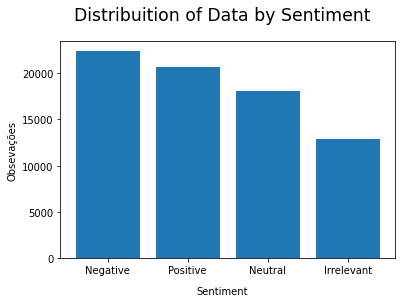

In [126]:
# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Distribuition of Data by Sentiment', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Sentiment', ha='center')
fig.text(0.002, 0.5, 'Obsevações', va='center', rotation='vertical')

plt.bar(data['sentiment'].value_counts().index, data['sentiment'].value_counts())

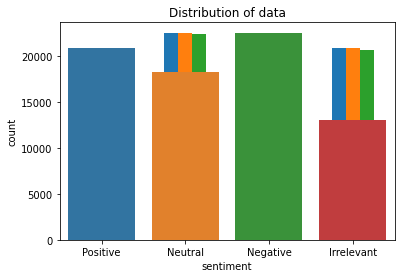

In [99]:
sentimentos = data['sentiment'].unique()
number_sentimentos = data['sentiment'].nunique()
entidades = data['entity'].unique()
number_entidades = data['entity'].nunique()

# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(sentimentos, rotation=0)
# Storing data in lists.
text, sentiment = list(data['Tweet content']), list(data['sentiment'])

sns.countplot(x='sentiment', data=data)

In [100]:
# dropna values
data = data.dropna().reset_index(drop=True)

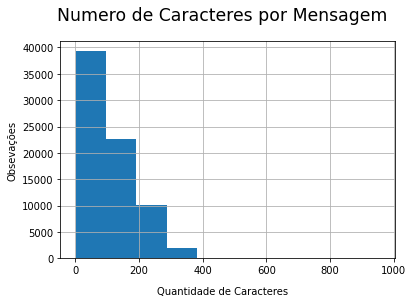

In [101]:
# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Numero de Caracteres por Mensagem', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Quantidade de Caracteres', ha='center')
fig.text(0.002, 0.5, 'Obsevações', va='center', rotation='vertical')

data['Tweet content'].str.len().hist(ax=axes)

Number of words per message


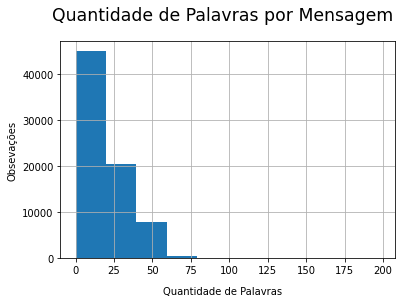

In [102]:

# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Quantidade de Palavras por Mensagem', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Quantidade de Palavras', ha='center')
fig.text(0.002, 0.5, 'Obsevações', va='center', rotation='vertical')
print('Number of words per message')
data['Tweet content'].str.split().map(lambda x: len(x)).hist(ax=axes)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


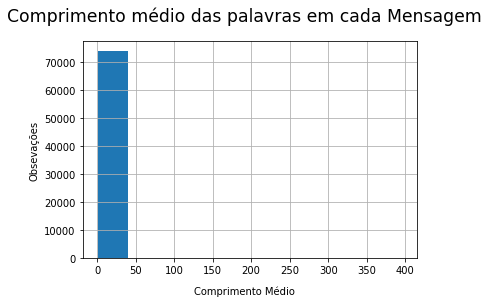

In [103]:


# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Comprimento médio das palavras em cada Mensagem', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Comprimento Médio', ha='center')
fig.text(0.002, 0.5, 'Obsevações', va='center', rotation='vertical')

data['Tweet content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(ax=axes)

In [104]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

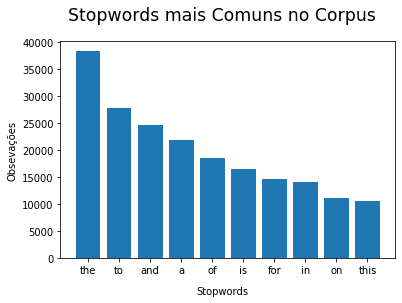

In [106]:
stop=set(stopwords.words('english'))
corpus=[]

sentences = data['Tweet content'].str.split().values.tolist()

corpus=[word for i in sentences for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Stopwords mais Comuns no Corpus', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Stopwords', ha='center')
fig.text(0.002, 0.5, 'Obsevações', va='center', rotation='vertical')

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

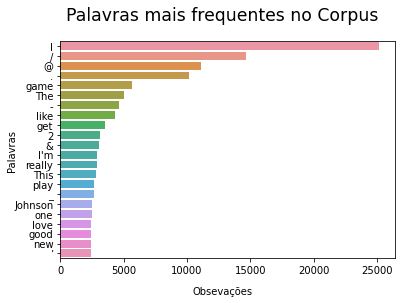

In [107]:

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

stop=set(stopwords.words('english'))

sentences = data['Tweet content'].str.split().values.tolist()

corpus=[word for i in sentences for word in i]

counter=Counter(corpus)
most=counter.most_common()
x, y=[], []
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# set up figure & axes
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# set title and axis labels
plt.suptitle('Palavras mais frequentes no Corpus', x=0.5, y=1, ha='center', fontsize='xx-large')
fig.text(0.5, 0.002, 'Obsevações', ha='center')
fig.text(0.002, 0.5, 'Palavras', va='center', rotation='vertical')

        
sns.barplot(x=y,y=x,ax=axes)

In [108]:
sentimentos = data['sentiment'].unique()
number_sentimentos = data['sentiment'].nunique()
entidades = data['entity'].unique()
number_entidades = data['entity'].nunique()

print('#'*100)
print(f'Sentiments (Targets) = {sentimentos}')
print(f'Quantidade de Sentiments (Targets) = {number_sentimentos}')
print('#'*100)
print(f'Entidades (Texto relacionado a entidade) = {entidades}')
print(f'Quantidade de Entidades (Texto relacionado a entidade) = {number_entidades}')

####################################################################################################
Sentiments (Targets) = ['Positive' 'Neutral' 'Negative' 'Irrelevant']
Quantidade de Sentiments (Targets) = 4
####################################################################################################
Entidades (Texto relacionado a entidade) = ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
Quantidade de Entidades (Texto relacionado a entidade) = 32


In [109]:
# data.groupby('sentiment').count()

# # Plotting the distribution for dataset.
# ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
# ax.set_xticklabels(sentimentos, rotation=0)
# # Storing data in lists.
# text, sentiment = list(data['Tweet content']), list(data['sentiment'])

# sns.countplot(x='sentiment', data=data)

In [110]:
print('Exemplo')
dataset_train.head()

Exemplo


,Tweet_ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [111]:
print('#'*100)
print(f'Columns: {dataset_train.columns}')
print('length of data is', len(dataset_train))
print(f'Shape: {dataset_train.shape}')
print('Count of columns in the data is:  ', len(dataset_train.columns))
print('Count of rows in the data is:  ', len(dataset_train))
print('#'*100)
print('Info')
print(dataset_train.info())
print('#'*100)
print('Column dtypes')
print(dataset_train.dtypes)


####################################################################################################
Columns: Index(['Tweet_ID', 'entity', 'sentiment', 'Tweet content'], dtype='object')
length of data is 74682
Shape: (74682, 4)
Count of columns in the data is:   4
Count of rows in the data is:   74682
####################################################################################################
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   Tweet content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
####################################################################################################
Column dtypes
Tweet_ID          int64
entity           object
sentime

In [112]:
print('#'*100)
qtd_null_values = np.sum(dataset_train.isnull().any(axis=1))
print(f'Number null values = {qtd_null_values}')


####################################################################################################
Number null values = 686


In [113]:
sentimentos = dataset_train['sentiment'].unique()
number_sentimentos = dataset_train['sentiment'].nunique()
entidades = dataset_train['entity'].unique()
number_entidades = dataset_train['entity'].nunique()

print('#'*100)
print(f'Sentiments (Targets) = {sentimentos}')
print(f'Quantidade de Sentiments (Targets) = {number_sentimentos}')
print('#'*100)
print(f'Entidades (Texto relacionado a entidade) = {entidades}')
print(f'Quantidade de Entidades (Texto relacionado a entidade) = {number_entidades}')

####################################################################################################
Sentiments (Targets) = ['Positive' 'Neutral' 'Negative' 'Irrelevant']
Quantidade de Sentiments (Targets) = 4
####################################################################################################
Entidades (Texto relacionado a entidade) = ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
Quantidade de Entidades (Texto relacionado a entidade) = 32


### Data Vizualization 
* Target

In [114]:
data.groupby('sentiment').count()

,Tweet_ID,entity,Tweet content
sentiment,,,
Irrelevant,12875,12875,12875
Negative,22358,22358,22358
Neutral,18108,18108,18108
Positive,20655,20655,20655


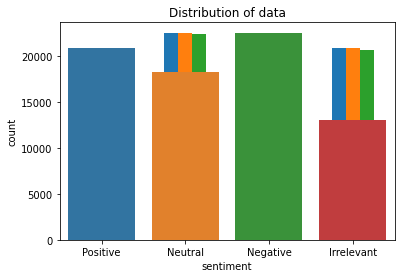

In [115]:
dataset_train.groupby('sentiment').count()

# Plotting the distribution for dataset.
ax = dataset_train.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(sentimentos, rotation=0)
# Storing data in lists.
text, sentiment = list(dataset_train['Tweet content']), list(dataset_train['sentiment'])

sns.countplot(x='sentiment', data=dataset_train)

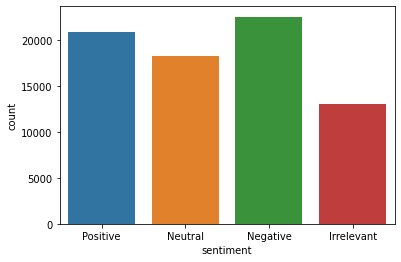

In [116]:
import seaborn as sns
sns.countplot(x='sentiment', data=dataset_train)

### WordCloud

In [117]:
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [118]:
texto = [str(value) for value in dataset_train['Tweet content'].to_list()]

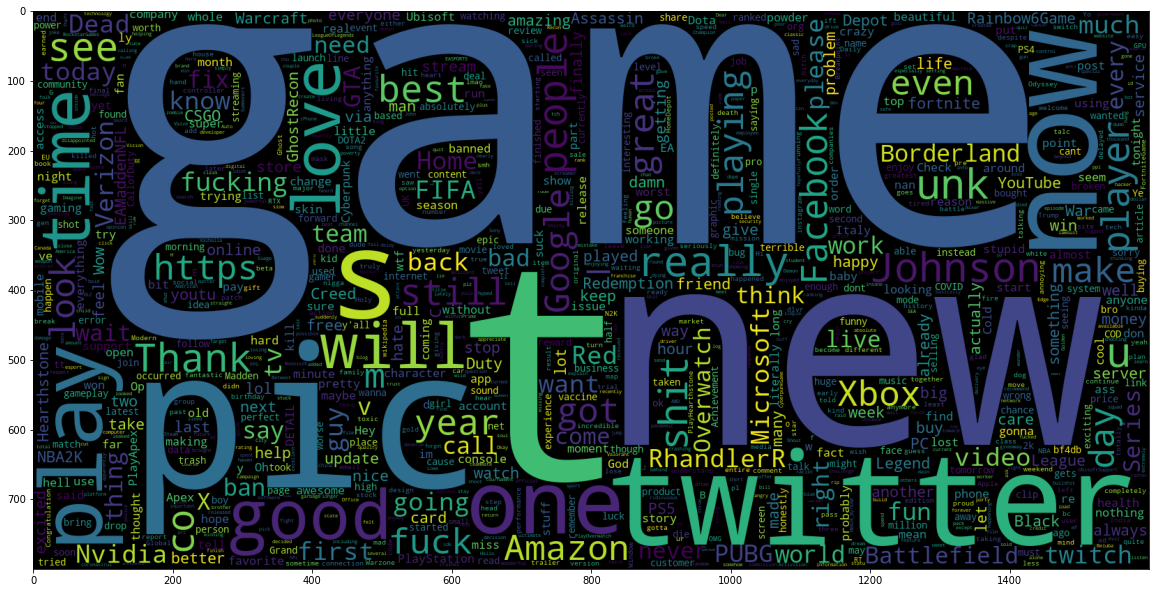

In [119]:
data_example = texto
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(texto))
plt.imshow(wc)